# **Multi-inference implicit chain of reasoning demonstration**

Here I attempt to solve this challenge [here](https://yuntiandeng.com/cv/challenge.png) by referencing the research paper and source code linked below.

| ||
|----------|----------|
| Research Credit | [here](https://arxiv.org/pdf/2311.01460.pdf) |
| Code Inspiration Credit | [github](https://github.com/da03/implicit_chain_of_thought/tree/main) |

In [1]:
import sys
import os

#For safe imports of everything
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)
sys.path.insert(False, parent_directory)

### **Dataset Generation**
Here we generate our test and train data. We generate our training data randomly such that it represents less than **1%** of possible observations. We also generate our tokenized data here as well.

---

The format of training and test datasets follow this format:

```
[input 1a] $$$ [input 1b]||[CoT 1a] $$$ [CoT 1b] #### [output 1a] $$$ [output 1b]
[input 2a] $$$ [input 2b]||[CoT 2a] $$$ [CoT 2b] #### [output 2a] $$$ [output 2b]
[input 3a] $$$ [input 3b]||[CoT 3a] $$$ [CoT 3b] #### [output 3a] $$$ [output 3b]
```

We can also test any particular case using the DatasetHandler so we create a custom prediction dataset as well.

In [2]:
from data.data import DatasetHandler

training_data_size = 77700
test_data_size = 7700

datahandler_train = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'train')
datahandler_test = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'test')

Now we generate datasets for each handler.

In [3]:
datahandler_train.generateDataset(size = training_data_size)


Generated raw train dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt of size 77700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt
tgt_avg:  21.0
src_avg:  13.0
ratios:  0.6190476190476191
tgt_avg:  15.0
src_avg:  13.0
ratios:  0.8666666666666667
---------------------------
Example features:
Full entry:  8 7 * 2 1 $$$ 5 1 * 6 1 <|endoftext|> 6 5 1 + 0 8 7 0 $$$ 0 9 0 + 0 5 1 0 <|endoftext|> #### 6 3 9 0 $$$ 0 4 2 0 <|endoftext|>
No CoT:  8 7 * 2 1 $$$ 5 1 * 6 1 <|endoftext|> #### 6 3 9 0 $$$ 0 4 2 0 <|endoftext|>
Only CoT:  8 7 * 2 1 $$$ 5 1 * 6 1 <|endoftext|> 6 5 1 + 0 8 7 0 $$$ 0 9 0 + 0 5 1 0 <|endoftext|>
Product input:  8 7 * 2 1 $$$ 5 1 * 6 1 <|endoftext|> 
---------------------------


In [4]:
datahandler_test.generateDataset(size = test_data_size)

Generated raw test dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_test_dataset.txt of size 7700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_test_dataset.txt
tgt_avg:  21.0
src_avg:  13.0
ratios:  0.6190476190476191
tgt_avg:  15.0
src_avg:  13.0
ratios:  0.8666666666666667
---------------------------
Example features:
Full entry:  5 4 * 5 4 $$$ 9 7 * 4 7 <|endoftext|> 5 2 2 + 0 0 8 1 $$$ 6 1 3 + 0 3 5 5 <|endoftext|> #### 5 2 0 2 $$$ 6 4 8 5 <|endoftext|>
No CoT:  5 4 * 5 4 $$$ 9 7 * 4 7 <|endoftext|> #### 5 2 0 2 $$$ 6 4 8 5 <|endoftext|>
Only CoT:  5 4 * 5 4 $$$ 9 7 * 4 7 <|endoftext|> 5 2 2 + 0 0 8 1 $$$ 6 1 3 + 0 3 5 5 <|endoftext|>
Product input:  5 4 * 5 4 $$$ 9 7 * 4 7 <|endoftext|> 
---------------------------


Here we allow the creation of a custom prediction. The custom prediction is of the form **a*b** and **c*d**.

In [5]:
#Custom prediction 
a=10
b=5
c=9
d=98

custom_prediction = DatasetHandler(parent_path = parent_directory, max_len = 1024, type = 'custom')
custom_prediction.generateDataset(a=10, b=5, c=9, d=98)

Generated raw custom dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt of size 1.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt
tgt_avg:  21.0
src_avg:  13.0
ratios:  0.6190476190476191
tgt_avg:  15.0
src_avg:  13.0
ratios:  0.8666666666666667
---------------------------
Example features:
Full entry:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0 <|endoftext|> #### 0 5 0 0 $$$ 2 8 8 0 <|endoftext|>
No CoT:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> #### 0 5 0 0 $$$ 2 8 8 0 <|endoftext|>
Only CoT:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0 <|endoftext|>
Product input:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 
---------------------------


### **Model Training**
Here we begin training our individual models. First we import everything we need.

---


In [6]:
from source.teacher import Teacher
from source.configurations import TeacherConfig

from source.thought_emulator import ThoughtEmulator
from source.configurations import ThoughtEmulatorConfig

from source.mindreading_emulator import MindReadingEmulator
from source.configurations import MindReadingEmulatorConfig

from source.implicit_student import ImplicitStudent


Now we initialize the configurations and models.

In [7]:
teacher_config = TeacherConfig()
teacher_model = Teacher(teacher_config)

t_emulator_config = ThoughtEmulatorConfig()
t_emulator_model = ThoughtEmulator(t_emulator_config, teacher_model)

mr_emulator_config = MindReadingEmulatorConfig()
mr_emulator_model = MindReadingEmulator(mr_emulator_config, teacher_model)

implicit_model = ImplicitStudent(mr_emulator_config, mindread = mr_emulator_model, thought = t_emulator_model)

##### **Teacher Model**
This model takes in inputs and generates a CoT and product as output.

In [8]:
teacher_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

  0%|          | 1/2429 [00:01<1:20:05,  1.98s/it]

Step: 0. PPL: 97.409218. Training Accuracy: 0.173713


  1%|          | 19/2429 [00:10<22:28,  1.79it/s] 


KeyboardInterrupt: 

##### **Thought Emulator Model**
This model takes the input and predicts the teacher states. We calculate a proxy for accuracy by taking the mean difference in layer states between the teacher model and itself.

  4%|▍         | 1/25 [00:00<00:19,  1.26it/s]

Step: 0. Loss: 7426.781250. Quasi Training Accuracy: 0.156185.


 16%|█▌        | 4/25 [00:01<00:08,  2.41it/s]

Step: 3. Loss: 4438.428711. Quasi Training Accuracy: 0.361866.


 28%|██▊       | 7/25 [00:02<00:06,  2.67it/s]

Step: 6. Loss: 3342.149414. Quasi Training Accuracy: 0.460645.


 40%|████      | 10/25 [00:04<00:05,  2.71it/s]

Step: 9. Loss: 2294.374512. Quasi Training Accuracy: 0.554252.


 52%|█████▏    | 13/25 [00:05<00:04,  2.58it/s]

Step: 12. Loss: 1533.328125. Quasi Training Accuracy: 0.626082.


 64%|██████▍   | 16/25 [00:06<00:03,  2.62it/s]

Step: 15. Loss: 1083.996338. Quasi Training Accuracy: 0.675304.


 76%|███████▌  | 19/25 [00:07<00:02,  2.60it/s]

Step: 18. Loss: 803.729492. Quasi Training Accuracy: 0.715703.


 88%|████████▊ | 22/25 [00:08<00:01,  2.57it/s]

Step: 21. Loss: 633.408630. Quasi Training Accuracy: 0.742138.


100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


Step: 24. Loss: 509.592560. Quasi Training Accuracy: 0.763962.
✔ Evaluating test dataset now...


100%|██████████| 3/3 [00:00<00:00,  9.79it/s]


Input:  4 3 * 9 0 $$$ 4 9 * 5 9  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.4152  0.0886  1.1963 -0.5306 -0.4088  0.2744 -1.132  -0.3765 -0.4034]

Input:  4 3 * 9 0 $$$ 4 9 * 5 9  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.4152  0.0886  1.1963 -0.5306 -0.4088  0.2744 -1.132  -0.3765 -0.4034]

Input:  4 3 * 9 0 $$$ 4 9 * 5 9  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.4152  0.0886  1.1963 -0.5306 -0.4088  0.2744 -1.132  -0.3765 -0.4034]

→ Loss: 415.963113; Quasi Test Accuracy: 0.789738; Quasi Training Accuracy: 0.763962.
Saving to c:\Users\Luke\multi_implicit_cot\models\thought_emulator


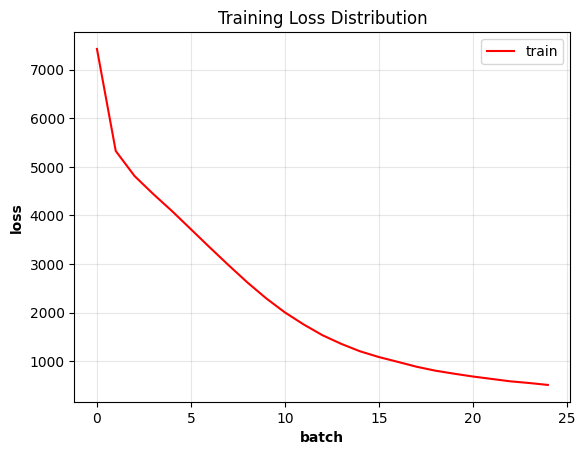

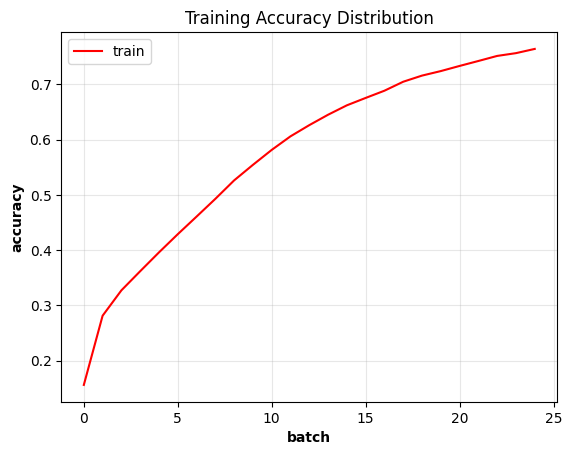

In [ ]:
t_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

##### **Mind Reading Emulator Model**
This model takes in the teacher states as input and predicts the output.

  4%|▍         | 1/25 [00:00<00:13,  1.80it/s]

Step: 0. Loss: 6.778487. Training Accuracy: 0.008929.


 16%|█▌        | 4/25 [00:01<00:08,  2.35it/s]

Step: 3. Loss: 2.456712. Training Accuracy: 0.323661.


 28%|██▊       | 7/25 [00:02<00:07,  2.47it/s]

Step: 6. Loss: 1.810990. Training Accuracy: 0.433036.


 40%|████      | 10/25 [00:04<00:05,  2.50it/s]

Step: 9. Loss: 1.594748. Training Accuracy: 0.477679.


 52%|█████▏    | 13/25 [00:05<00:04,  2.50it/s]

Step: 12. Loss: 1.451219. Training Accuracy: 0.520089.


 64%|██████▍   | 16/25 [00:06<00:03,  2.50it/s]

Step: 15. Loss: 1.451691. Training Accuracy: 0.506696.


 76%|███████▌  | 19/25 [00:07<00:02,  2.48it/s]

Step: 18. Loss: 1.421798. Training Accuracy: 0.520089.


 88%|████████▊ | 22/25 [00:08<00:01,  2.49it/s]

Step: 21. Loss: 1.380186. Training Accuracy: 0.520089.


100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


Step: 24. Loss: 1.285439. Training Accuracy: 0.547619.
✔ Evaluating test dataset now...


100%|██████████| 3/3 [00:13<00:00,  4.58s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Target:  #### 6 5 1 6 $$$ 0 0 0 0 
Predicted:  #### 0 0 0 0 $$$ 0 0 0 0 

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Target:  #### 0 7 0 2 $$$ 2 5 6 2 
Predicted:  #### 0 0 0 0 $$$ 0 0 0 0 

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Target:  #### 2 0 3 1 $$$ 9 4 1 3 
Predicted:  #### 0 2 2 0 $$$ 0 4 4 0 

→ Perplexitity: 3.528283; Test Accuracy: 0.000000; Training Accuracy: 0.548238.
Saving to c:\Users\Luke\multi_implicit_cot\models\mindreading_emulator


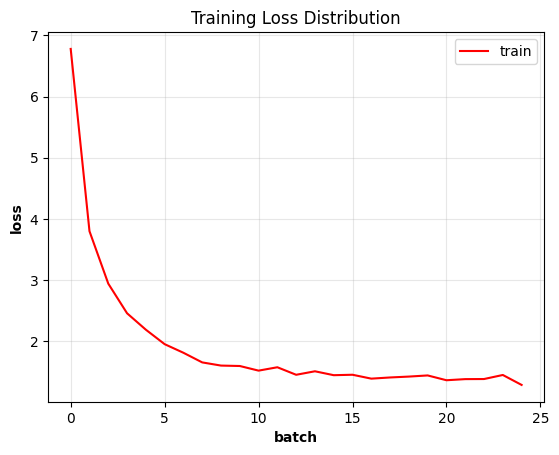

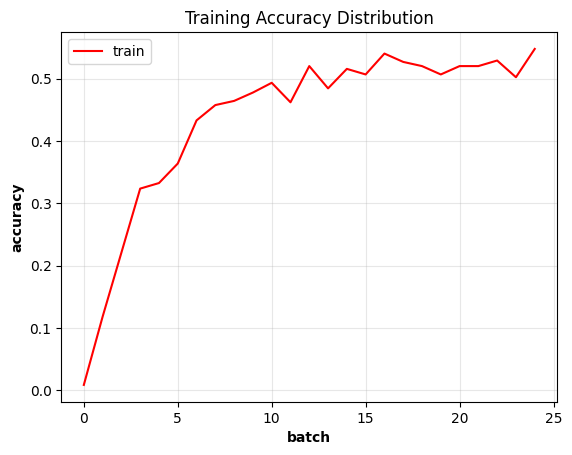

In [ ]:
mr_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

##### **Implicit Model**
This model takes the input and predicts teacher states, and uses the teacher states to predict the output. The teacher states are used implicitly to mimic CoT reasoning internally. It combines the thought emulator and the mind emulator model.

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:13,  1.73it/s]

Step: 0. Loss: 1.269665. Training Accuracy: 0.537946.


 16%|█▌        | 4/25 [00:01<00:08,  2.48it/s]

Step: 3. Loss: 1.660695. Training Accuracy: 0.433036.


 28%|██▊       | 7/25 [00:02<00:06,  2.63it/s]

Step: 6. Loss: 1.439530. Training Accuracy: 0.542411.


 40%|████      | 10/25 [00:03<00:05,  2.66it/s]

Step: 9. Loss: 1.328318. Training Accuracy: 0.526786.


 52%|█████▏    | 13/25 [00:05<00:04,  2.68it/s]

Step: 12. Loss: 1.250454. Training Accuracy: 0.524554.


 64%|██████▍   | 16/25 [00:06<00:03,  2.69it/s]

Step: 15. Loss: 1.237119. Training Accuracy: 0.535714.


 76%|███████▌  | 19/25 [00:07<00:02,  2.69it/s]

Step: 18. Loss: 1.185838. Training Accuracy: 0.560268.


 88%|████████▊ | 22/25 [00:08<00:01,  2.69it/s]

Step: 21. Loss: 1.170427. Training Accuracy: 0.555804.


100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


Step: 24. Loss: 1.205808. Training Accuracy: 0.539683.
✔ Evaluating test dataset now...


100%|██████████| 3/3 [00:13<00:00,  4.36s/it]

Input:  6 7 * 1 8 $$$ 0 0 * 4 1 
Target:  #### 6 5 1 6 $$$ 0 0 0 0 
Predicted:  #### 0 7 7 0 $$$ 0 0 0 0 

Input:  3 2 * 0 9 $$$ 4 3 * 8 7 
Target:  #### 0 7 0 2 $$$ 2 5 6 2 
Predicted:  #### 0 2 2 0 $$$ 0 6 4 0 

Input:  2 4 * 1 3 $$$ 7 6 * 7 4 
Target:  #### 2 0 3 1 $$$ 9 4 1 3 
Predicted:  #### 0 4 2 2 $$$ 6 6 4 4 

→ Perplexitity: 3.238169; Test Accuracy: 0.000000; Training Accuracy: 0.553803.
Saving to c:\Users\Luke\multi_implicit_cot\models\implict_thought_emulator


Saving to c:\Users\Luke\multi_implicit_cot\models\implict_mindreading_emulator


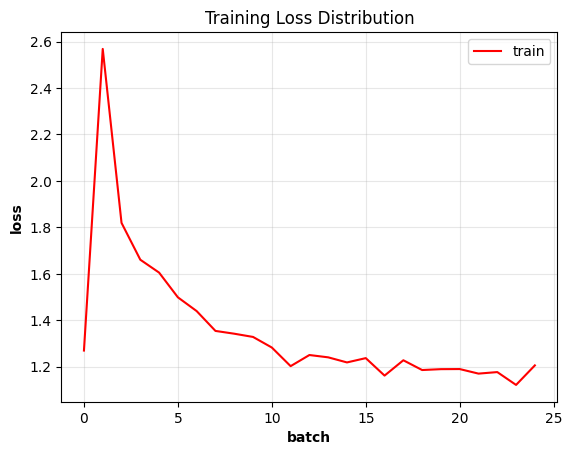

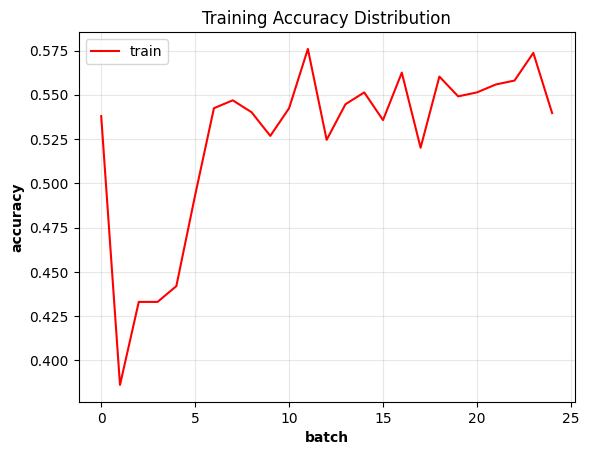

In [ ]:
implicit_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

### **Prediction Demo**
Here we generate our custom test case to see results for each model. We include both the **thought emulator** and **mind reading emulator** to see how well it maps to and from teacher states.

---

In [ ]:
teacher_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

Input:  0 1 * 5 0 $$$ 9 0 * 8 9 
Target:  0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0  #### 0 5 0 0 $$$ 2 8 8 0 
Predicted:  0 0 0 + 0 0 0 0 $$$ 0 0 0 + 0 0 0  #### 0 0 0 0 $$$ 0 0 0 



In [ ]:
t_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00, 22.28it/s]

Input:  0 1 * 5 0 $$$ 9 0 * 8 9  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.4151  0.0887  1.1963 -0.5306 -0.4087  0.2745 -1.132  -0.3764 -0.4033]


In [ ]:
mr_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.3245 -0.0403  0.9019 -0.2549 -0.3514  0.2172 -1.2913 -0.3146 -0.3504]
Target:  #### 0 5 0 0 $$$ 2 8 8 0 
Predicted:  #### 0 0 0 0 $$$ 0 0 0 0 



In [ ]:
implicit_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

Input:  0 1 * 5 0 $$$ 9 0 * 8 9 
Target:  #### 0 5 0 0 $$$ 2 8 8 0 
Predicted:  #### 0 0 0 0 $$$ 0 0 0 0 

